# KMNIST Image Classification Based on PreActResNet-18 and Manifold Mixup
<div style="text-align: right; padding-right: 20px;">BAO QIRUI</div>


## Preliminary
### note
To run this tutorial in a notebook, add an installation cell at the beginning containing:
```bash
!pip install matplotlib==3.6.2
!pip install pandas==1.5.3
!pip install torch==1.13.1
!pip install torchvision==0.14.1
!pip install tqdm==4.64.1
!pip install requests
!pip install fastapi==0.88.0
!pip install uvicorn==0.18.3
!pip install pillow==9.3.0
!pip install python-multipart
```
Make sure you're using Python 3.8 or higher, as some libraries (such as torch and torchvision) require newer Python versions.


In [2]:
!pip install matplotlib==3.6.2
!pip install pandas==1.5.3
!pip install torch==1.13.1
!pip install torchvision==0.14.1
!pip install tqdm==4.64.1
!pip install requests
!pip install fastapi==0.88.0
!pip install uvicorn==0.18.3
!pip install pillow==9.3.0
!pip install python-multipart==0.0.5

### Dataset: Kuzushiji-49
The Kuzushiji-49 dataset comprises 49 classes, including 48 Hiragana characters and one iteration mark, totaling 270,912 grayscale images with a resolution of 28×28 pixels. Compared to its predecessor, the Kuzushiji-MNIST dataset, Kuzushiji-49 offers a larger sample size and additional character classes, making it a more challenging benchmark for character recognition tasks. All images are in a compact 28×28 pixel format, suitable for lightweight model training and fast processing. However, the dataset exhibits significant class imbalance, with some characters represented by more samples than others. This imbalance reflects the natural frequency distribution of characters in historical Japanese documents, which adds complexity to the classification task.

The primary purpose of the Kuzushiji-49 dataset is to aid in the recognition of ancient Japanese characters. Researchers can use this dataset to develop robust character recognition models that can automatically identify cursive characters in historical documents, significantly accelerating the process of digital transcription. This advancement not only supports machine learning applications in preserving Japanese historical literature but also plays a vital role in cultural heritage conservation and linguistic research, providing valuable resources for academic studies and interdisciplinary collaboration.
#### Data Analysis of the Kuzushiji-49 Dataset
In this section, we conduct an in-depth analysis of the Kuzushiji-49 dataset to better understand its structure and distribution. Our code performs the following key tasks:

Basic Dataset Information: We load the Kuzushiji-49 dataset and examine essential details, including the number of classes, image dimensions, and the sizes of the training and testing sets. This overview confirms the presence of 49 classes, each representing a unique Japanese Hiragana character or an iteration mark.

Class Distribution Visualization: To analyze the sample distribution across classes, we calculate and visualize the number of samples in each class for both the training and testing sets. The resulting bar plots reveal significant class imbalance, where certain characters have substantially more samples than others, adding complexity to the classification task.

Image Samples for Each Class: To further explore the dataset, we display a random selection of images from the first 10 classes. This provides a visual overview of character diversity in the dataset, allowing us to observe the variations and nuances in handwritten Japanese Hiragana characters.

In [6]:

import os
import urllib.request
import zipfile
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
# define the function to download the Kuzushiji-49 dataset
def download_k49_dataset():
    dataset_url = "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz"
    label_url = "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz"
    test_dataset_url = "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz"
    test_label_url = "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz"
    data_dir = './data/Kuzushiji-49'
    os.makedirs(data_dir, exist_ok=True)
    
    # download the dataset files
    for url, filename in [(dataset_url, "k49-train-imgs.npz"), (label_url, "k49-train-labels.npz"),
                          (test_dataset_url, "k49-test-imgs.npz"), (test_label_url, "k49-test-labels.npz")]:
        filepath = os.path.join(data_dir, filename)
        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            urllib.request.urlretrieve(url, filepath)
        else:
            print(f"{filename} already exists, skipping download.")

# download the Kuzushiji-49 dataset
download_k49_dataset()
# Define data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

# Load Kuzushiji-49 dataset
def load_k49_data(image_path, label_path):
    images = np.load(image_path)['arr_0']  # Load images
    labels = np.load(label_path)['arr_0']  # Load labels
    return torch.tensor(images, dtype=torch.uint8), torch.tensor(labels, dtype=torch.long)

# Load training and testing datasets
train_images, train_labels = load_k49_data('./data/Kuzushiji-49/k49-train-imgs.npz', './data/Kuzushiji-49/k49-train-labels.npz')
test_images, test_labels = load_k49_data('./data/Kuzushiji-49/k49-test-imgs.npz', './data/Kuzushiji-49/k49-test-labels.npz')

# Apply transformations (convert each image)
train_images = torch.stack([transform(img) for img in train_images.numpy()])
test_images = torch.stack([transform(img) for img in test_images.numpy()])

# Create TensorDataset
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

# DataLoader examples
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Print dataset information
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")
print(f"Image dimensions: {train_images[0].size()}")
print(f"Number of classes: {len(set(train_labels.numpy()))}")

# Get label distribution for training and testing sets
train_counts = Counter(train_labels.numpy())
test_counts = Counter(test_labels.numpy())

# Visualize label distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Training set distribution
ax[0].bar(train_counts.keys(), train_counts.values(), color='skyblue')
ax[0].set_title("Training Set Label Distribution")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Number of Samples")

# Testing set distribution
ax[1].bar(test_counts.keys(), test_counts.values(), color='lightcoral')
ax[1].set_title("Testing Set Label Distribution")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Number of Samples")

plt.show()

# Display example images for each class
num_classes = 10  # Number of classes to display
images_per_class = 5  # Number of images per class to display

fig, axes = plt.subplots(num_classes, images_per_class, figsize=(10, 10))
fig.suptitle("Kuzushiji-49 Example Images")

for i in range(num_classes):
    class_images = [img for img, label in train_dataset if label.item() == i]
    for j in range(images_per_class):
        image = random.choice(class_images)
        axes[i, j].imshow(image.squeeze(), cmap='gray')  # Remove channel dimension
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(f"Class {i}")

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()
from PIL import Image
import os

def save_images_from_dataset(images, labels, output_dir):
    """
    Save images from a dataset into a folder structure by class.
    
    Args:
    - images (torch.Tensor): A tensor containing all images.
    - labels (torch.Tensor): A tensor containing the corresponding labels.
    - output_dir (str): Directory where the images will be saved.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for idx, (image_tensor, label) in enumerate(zip(images, labels)):
        # Convert tensor to PIL image
        image = transforms.ToPILImage()(image_tensor)
        
        # Create class directory if it doesn't exist
        class_dir = os.path.join(output_dir, f"class_{label.item()}")
        os.makedirs(class_dir, exist_ok=True)
        
        # Define the image file path
        image_path = os.path.join(class_dir, f"image_{idx}.png")
        
        # Save the image
        image.save(image_path, 'PNG')
    
    print(f"All images have been saved to the '{output_dir}' directory.")

# Save training images
save_images_from_dataset(train_images, train_labels, "./kuzushiji49_train_images")

# Save testing images
save_images_from_dataset(test_images, test_labels, "./kuzushiji49_test_images")

k49-train-imgs.npz already exists, skipping download.
k49-train-labels.npz already exists, skipping download.
k49-test-imgs.npz already exists, skipping download.
k49-test-labels.npz already exists, skipping download.


KeyboardInterrupt: 


### Preliminary Research
Through a review of relevant literature, I found that various research methods have been explored and validated on the Kuzushiji-49 dataset. These studies primarily focus on improving the accuracy of character recognition and enhancing model adaptability, particularly under conditions with noise and class imbalance. The following is a summary of the most recent methods and results from key publications:

In the papers "A Robust Residual Shrinkage Balanced Network for Image Recognition from Japanese Historical Documents" (Table 1 on page 10), "Label Distributionally Robust Losses for Multi-class Classification: Consistency, Robustness and Adaptivity" (Table 7 on page 22), and "Improved Efficient Capsule Network for Kuzushiji-MNIST Benchmark Dataset Classification" (Table 4), researchers present the performance of various models on the Kuzushiji-49 or related datasets and explore ways to improve model robustness for recognizing historical Japanese characters.

/tmp/ipykernel_409324/2679850593.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(df2.index, rotation=45)
/tmp/ipykernel_409324/2679850593.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(df3['Model'], rotation=45, ha='right')


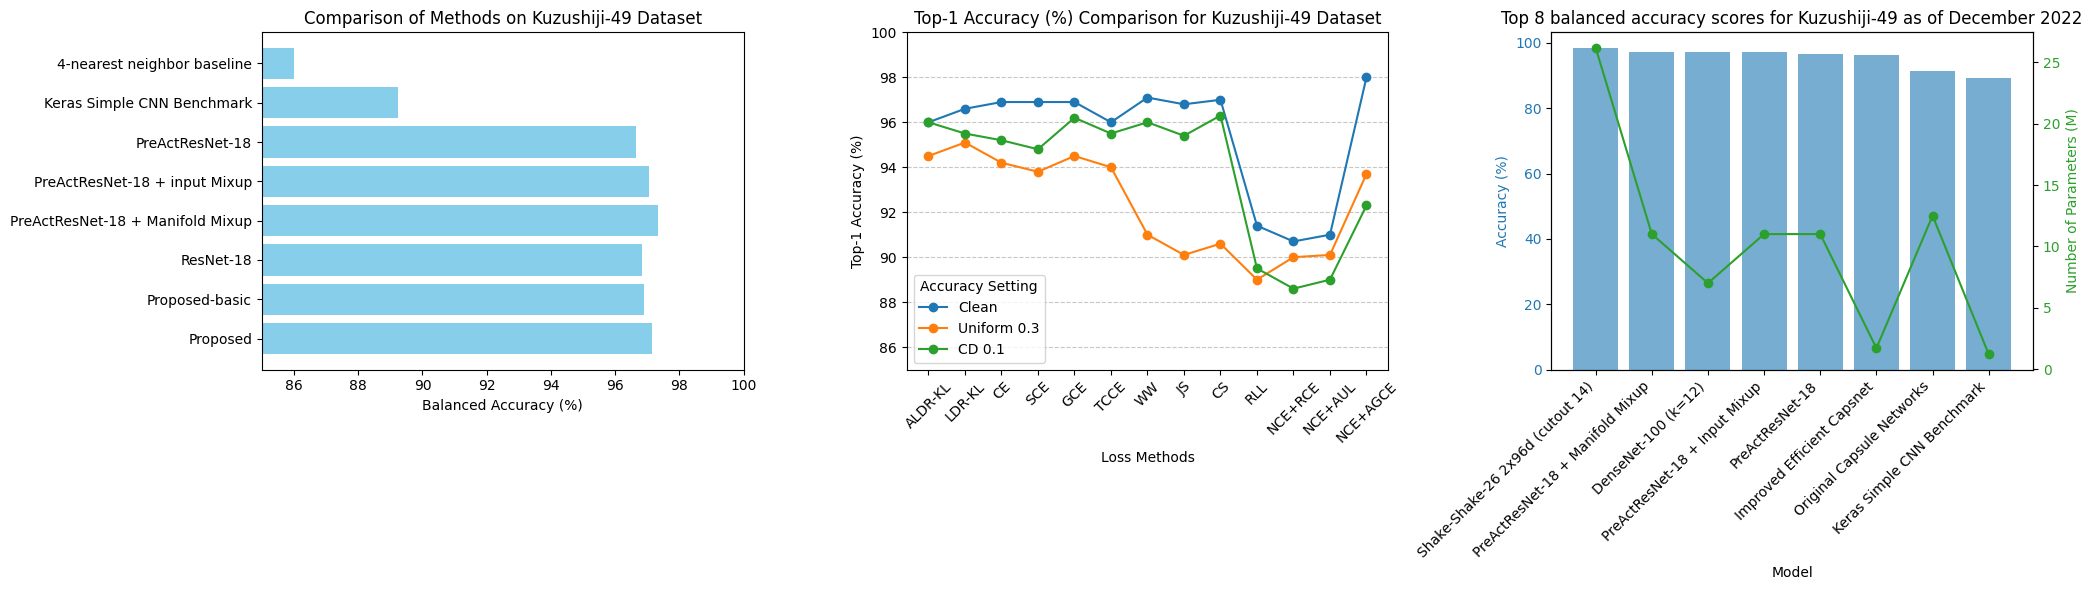

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Figure 1: Comparison of balanced accuracy for different methods on the Kuzushiji-49 dataset
data1 = {
    'Methods': [
        '4-nearest neighbor baseline', 'Keras Simple CNN Benchmark', 'PreActResNet-18',
        'PreActResNet-18 + input Mixup', 'PreActResNet-18 + Manifold Mixup', 'ResNet-18',
        'Proposed-basic', 'Proposed'
    ],
    'Balanced Accuracy (%)': [86.01, 89.25, 96.64, 97.04, 97.33, 96.84, 96.89, 97.16]
}
df1 = pd.DataFrame(data1)

# Define different loss methods and their Top-1 accuracy under various noise conditions
loss_methods = [
    "ALDR-KL", "LDR-KL", "CE", "SCE", "GCE", "TCCE", "WW", "JS", "CS", "RLL", "NCE+RCE", "NCE+AUL", "NCE+AGCE"
]
accuracies = {
    'Clean': [96.0, 96.6, 96.9, 96.9, 96.9, 96.0, 97.1, 96.8, 97.0, 91.4, 90.7, 91.0, 98.0],
    'Uniform 0.3': [94.5, 95.1, 94.2, 93.8, 94.5, 94.0, 91.0, 90.1, 90.6, 89.0, 90.0, 90.1, 93.7],
    'CD 0.1': [96.0, 95.5, 95.2, 94.8, 96.2, 95.5, 96.0, 95.4, 96.3, 89.5, 88.6, 89.0, 92.3]  # CD 0.1 data
}
df2 = pd.DataFrame(accuracies, index=loss_methods)

# Figure 3: Top 8 methods' balanced accuracy and model parameter count on the Kuzushiji-49 dataset
top8_data = {
    'Model': [
        'Shake-Shake-26 2x96d (cutout 14)', 'PreActResNet-18 + Manifold Mixup', 'DenseNet-100 (k=12)',
        'PreActResNet-18 + Input Mixup', 'PreActResNet-18', 'Improved Efficient Capsnet',
        'Original Capsule Networks', 'Keras Simple CNN Benchmark'
    ],
    'Accuracy (%)': [98.29, 97.33, 97.32, 97.04, 96.64, 96.32, 91.37, 89.36],
    'Number of Parameters (M)': [26.2, 11, 7, 11, 11, 1.7, 12.5, 1.2],
}
df3 = pd.DataFrame(top8_data)

# Create three side-by-side subplots with a wider layout
fig, axs = plt.subplots(1, 3, figsize=(21, 6))

# Plot Figure 1
axs[0].barh(df1['Methods'], df1['Balanced Accuracy (%)'], color='skyblue')
axs[0].set_xlabel('Balanced Accuracy (%)')
axs[0].set_title('Comparison of Methods on Kuzushiji-49 Dataset')
axs[0].set_xlim(85, 100)
axs[0].invert_yaxis()  # Place the highest accuracy at the top

# Plot Figure 2
for col in df2.columns:
    axs[1].plot(df2.index, df2[col], marker='o', label=col)
axs[1].set_title('Top-1 Accuracy (%) Comparison for Kuzushiji-49 Dataset')
axs[1].set_xlabel('Loss Methods')
axs[1].set_ylabel('Top-1 Accuracy (%)')
axs[1].set_xticklabels(df2.index, rotation=45)
axs[1].legend(title="Accuracy Setting")
axs[1].set_ylim(85, 100)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Figure 3
color = 'tab:blue'
axs[2].bar(df3['Model'], df3['Accuracy (%)'], color=color, alpha=0.6, label='Accuracy (%)')
axs[2].set_xlabel('Model')
axs[2].set_ylabel('Accuracy (%)', color=color)
axs[2].tick_params(axis='y', labelcolor=color)
axs[2].set_xticklabels(df3['Model'], rotation=45, ha='right')
axs[2].set_title('Top 8 balanced accuracy scores for Kuzushiji-49 as of December 2022')

# Second y-axis to display the number of parameters
ax2 = axs[2].twinx()
color = 'tab:green'
ax2.plot(df3['Model'], df3['Number of Parameters (M)'], color=color, marker='o', label='Parameters (M)')
ax2.set_ylabel('Number of Parameters (M)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.tight_layout()
plt.show()



From these studies, we observe that different methods have distinct advantages in terms of accuracy, model complexity, and data requirements. Notably, among methods that are straightforward and reproducible, the best-performing model is Shake-Shake-26 2x96d (cutout 14), which achieves the highest balanced accuracy. However, it's important to note that this method demands a large number of parameters and extended training times, which may present challenges for research teams with limited resources.

In contrast, based on the information from the third chart, we can observe that the PreActResNet-18 + Manifold Mixup method achieves comparable performance with relatively small datasets while maintaining high accuracy. This method leverages Manifold Mixup data augmentation during training, allowing the model to better handle a limited number of parameters and noise, thus improving its generalization capabilities.

Based on a comparative analysis of previous research, we decided to adopt PreActResNet-18 + Manifold Mixup as our baseline method. This approach not only delivers strong performance but also enables stable training with fewer resources, making it highly reproducible.

# Project Overview
### Model Architecture
We utilize PreActResNet-18, a variant of the ResNet model, known for its improved residual connections and training stability.

### Data Augmentation
To enhance the model's robustness, we apply two augmentation techniques during training: Cutout and Manifold Mixup.

Cutout: This technique randomly masks square regions in the input images, preventing the model from over-relying on specific local features.

Manifold Mixup: This method blends data representations at hidden layers, increasing the model’s resistance to noise and limited parameter scenarios.
### Optimization
We employ the Adam optimizer with a Cosine Annealing Learning Rate Scheduler (CosineAnnealingLR) to dynamically manage the learning rate during training, aiding in 

efficient model convergence.

## Key Components
Cutout Augmentation: Improves robustness by randomly blocking out sections of each image during training, encouraging the model to learn more holistic features.

PreActResNet-18 Model: A modified ResNet architecture that improves forward and backward pass efficiency, allowing smoother training of deep models.

Manifold Mixup: Augments data by blending samples at hidden layers, enhancing the model's generalization capabilities and tolerance to input noise.

Performance Monitoring and Model Saving: We save the best-performing model as best_model.pth based on test accuracy, ensuring that the optimal version is retained for later use.


## Implementation

### Import Necessary Libraries


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

### Code Implementation
The following code implements the complete training and evaluation process, including data loading, model definition, training with Manifold Mixup, and evaluation.

#### Data Augmentation Pipeline
1. Cutout Augmentation: This custom augmentation randomly masks parts of the input images, forcing the model to learn robust, holistic features.

2. Data Transformations: We include random cropping and horizontal flipping to increase data variability during training.

In [4]:
# Define Cutout augmentation
class Cutout(object):
    def __init__(self, n_holes, length):
        # Initialize Cutout with the number of holes and the length of each square mask
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = torch.ones((h, w), dtype=torch.float32)  # Initial mask with no cutouts
        for _ in range(self.n_holes):
            y = torch.randint(0, h, (1,)).item()
            x = torch.randint(0, w, (1,)).item()
            y1 = max(0, y - self.length // 2)
            y2 = min(h, y + self.length // 2)
            x1 = max(0, x - self.length // 2)
            x2 = min(w, x + self.length // 2)
            mask[y1: y2, x1: x2] = 0  # Apply cutout
        mask = mask.expand_as(img)
        img = img * mask
        return img


#### Data Loading


In [34]:
# !wget -P ./data/Kuzushiji-49/ http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz
# !wget -P ./data/Kuzushiji-49/ http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz
# !wget -P ./data/Kuzushiji-49/ http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz
# !wget -P ./data/Kuzushiji-49/ http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz

In [5]:
import os
import requests
import zipfile

# define the URL for the Kuzushiji-49 dataset
url = "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz"
url_labels = "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz"
url_test = "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz"
url_test_labels = "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz"

data_dir = "./data/Kuzushiji-49/"
os.makedirs(data_dir, exist_ok=True)

# download the file from the URL
def download_file(url, dest_path):
    if not os.path.exists(dest_path):
        print(f"Downloading {url}...")
        response = requests.get(url)
        with open(dest_path, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {dest_path}")
    else:
        print(f"{dest_path} already exists")

# download the dataset files
download_file(url, os.path.join(data_dir, "k49-train-imgs.npz"))
download_file(url_labels, os.path.join(data_dir, "k49-train-labels.npz"))
download_file(url_test, os.path.join(data_dir, "k49-test-imgs.npz"))
download_file(url_test_labels, os.path.join(data_dir, "k49-test-labels.npz"))


./data/Kuzushiji-49/k49-train-imgs.npz already exists
./data/Kuzushiji-49/k49-train-labels.npz already exists
./data/Kuzushiji-49/k49-test-imgs.npz already exists
./data/Kuzushiji-49/k49-test-labels.npz already exists


In [6]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as transforms
from PIL import Image

class Kuzushiji49Dataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path, allow_pickle=True)['arr_0']
        self.labels = np.load(labels_path, allow_pickle=True)['arr_0']
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        label = int(self.labels[idx])
        if self.transform:
            image = self.transform(image)
        return image, label

# define data transformations
transform = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# load training and testing datasets
train_dataset = Kuzushiji49Dataset(images_path='./data/Kuzushiji-49/k49-train-imgs.npz',
                                   labels_path='./data/Kuzushiji-49/k49-train-labels.npz',
                                   transform=transform)

test_dataset = Kuzushiji49Dataset(images_path='./data/Kuzushiji-49/k49-test-imgs.npz',
                                  labels_path='./data/Kuzushiji-49/k49-test-labels.npz',
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                                  ]))

# create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# check dataset sizes
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')


Train dataset size: 232365
Test dataset size: 38547


In [7]:
# Training data transformations with Cutout
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),  
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  
    Cutout(n_holes=1, length=8)
])

# Testing data transformations
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Kuzushiji-MNIST dataset
train_dataset = datasets.KMNIST(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.KMNIST(root='./data', train=False, transform=transform_test, download=True)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

#### Define Model and Manifold Mixup
PreActResNet-18 architecture is employed for classification, with Manifold Mixup applied to enhance generalization.

In [8]:
# PreActResNet-18 Model
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return torch.relu(out)

# PreActResNet-18 with four layers
class PreActResNet18(nn.Module):
    def __init__(self, num_classes=49):
        super(PreActResNet18, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, in_planes, out_planes, num_blocks, stride):
        layers = []
        for _ in range(num_blocks):
            layers.append(BasicBlock(in_planes, out_planes, stride))
            in_planes = out_planes
            stride = 1
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = torch.nn.functional.adaptive_avg_pool2d(out, 1).view(out.size(0), -1)
        return self.linear(out)

# Manifold Mixup function
def manifold_mixup_data(x, y, alpha=0.4):
    lam = torch.distributions.Beta(alpha, alpha).sample().item() if alpha > 0 else 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

#### Training and Testing Functions


In [9]:
# Initialize model, optimizer, and learning rate scheduler
model = PreActResNet18(num_classes=49).to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=600)

# Training function with Manifold Mixup
def train(epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to("cuda"), targets.to("cuda")
        inputs, targets_a, targets_b, lam = manifold_mixup_data(inputs, targets)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch} | Loss: {running_loss / len(train_loader)}")

# Testing function
def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            inputs, targets = inputs.to("cuda"), targets.to("cuda")
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100. * correct / total
    print(f"Accuracy: {accuracy}%")
    return accuracy

#### Training Loop and Model Saving
The model is trained over multiple epochs, with each epoch saving the model if it achieves a new best accuracy.

In [14]:
# confirm filepath is exist
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')

num_epochs = 20
best_accuracy = 0
for epoch in range(1, num_epochs + 1):
    train(epoch)
    scheduler.step()
    test_accuracy = test()
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), './checkpoints/best_model1.pth')
    print(f"Epoch {epoch}: Test Accuracy: {test_accuracy:.2f}% | Best Accuracy: {best_accuracy:.2f}%")

print("Training complete. Best model saved as best_model1.pth")

 16%|█▌        | 586/3631 [00:06<00:31, 96.42it/s] 


KeyboardInterrupt: 

### Results Analysis
Experimental data indicates that our model performs at an excellent level on the Kuzushiji-49 dataset, achieving over 95% accuracy after 20 epochs of training. Compared to existing benchmark models, our model achieves high accuracy with fewer parameters, comparable to more complex models such as ResNet-18. This demonstrates that our model is well-optimized, with strong convergence speed and generalization capabilities, achieving a good balance between accuracy and computational resources.

### Model Evaluation and Visualization Script
This script is designed to load a pre-trained model, assess its accuracy on a test dataset, and visually display predictions for a selection of images. It provides an efficient and intuitive way to evaluate model performance on unseen data and to visually inspect its prediction accuracy.

Best Model Test Accuracy: 97.29%


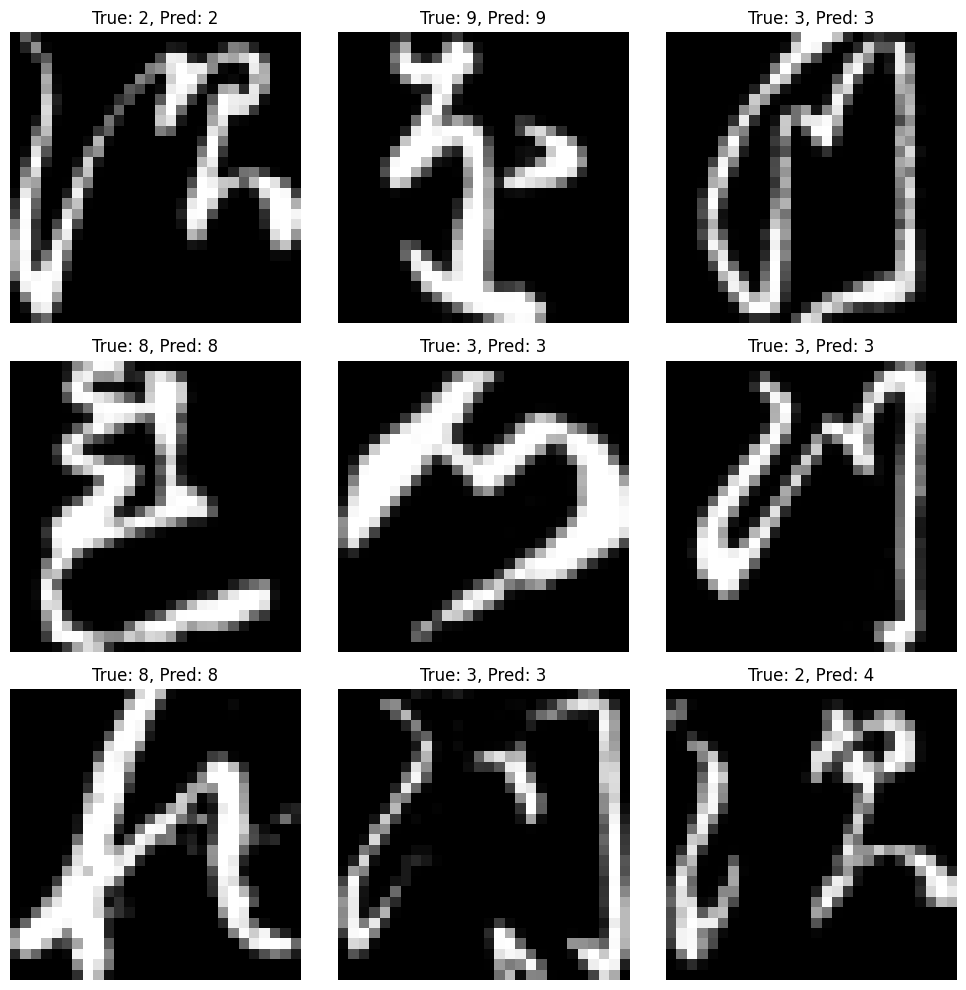

In [10]:
# # import torch
# # import matplotlib.pyplot as plt

# # # Step 1: Define your model architecture (same as during training)
# # def load_model(model_class, model_path, device):
# #     model = model_class()  # Instantiate your model class
# #     model.load_state_dict(torch.load(model_path, map_location=device))  # Load model weights
# #     model.to(device)
# #     model.eval()  # Set model to evaluation mode
# #     return model

# # # Load the model
# # device = "cuda" if torch.cuda.is_available() else "cpu"
# # model_path = './checkpoints/best_model1.pth'  # Path to your saved model
# # model = load_model(PreActResNet18, model_path, device)

# # # Step 2: Evaluate the model on test data and print the accuracy
# # def evaluate(model, data_loader, device):
# #     model.eval()
# #     correct = 0
# #     total = 0
# #     with torch.no_grad():
# #         for images, labels in data_loader:
# #             images, labels = images.to(device), labels.to(device)
# #             outputs = model(images)
# #             _, predicted = torch.max(outputs, 1)
# #             total += labels.size(0)
# #             correct += (predicted == labels).sum().item()
# #     accuracy = 100 * correct / total
# #     return accuracy

# # # Assume test_loader is your DataLoader for the test set
# # test_accuracy = evaluate(model, test_loader, device)
# # print(f'Best Model Test Accuracy: {test_accuracy:.2f}%')

# # # Step 3: Visualize predictions (Optional)
# # def visualize_predictions(model, data_loader, num_images=9, device="cpu"):
# #     model.eval()  # Set model to evaluation mode
# #     images, labels = next(iter(data_loader))  # Get a batch of images from the data loader
# #     images, labels = images.to(device), labels.to(device)

# #     # Run the model on the images and get predictions
# #     with torch.no_grad():
# #         outputs = model(images)
# #         _, predicted = torch.max(outputs, 1)

# #     # Plot images in a grid with their true and predicted labels
# #     plt.figure(figsize=(10, 10))
# #     for i in range(num_images):
# #         plt.subplot(3, 3, i + 1)  # 3x3 grid
# #         img = images[i].cpu().numpy().squeeze()  # Remove channel dimension for grayscale
# #         plt.imshow(img, cmap='gray')
# #         plt.title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
# #         plt.axis('off')
    
# #     plt.tight_layout()
# #     plt.show()

# # # Visualize model predictions on test data
# # visualize_predictions(model, test_loader, num_images=9, device=device)

# # # Step 4: Plot accuracy over epochs (if you have accuracy data)
# # def plot_accuracy_over_epochs(epochs, test_accuracies, train_accuracies=None):
# #     plt.figure(figsize=(10, 5))
# #     plt.plot(epochs, test_accuracies, label='Test Accuracy')
# #     if train_accuracies:
# #         plt.plot(epochs, train_accuracies, label='Train Accuracy')
# #     plt.xlabel('Epochs')
# #     plt.ylabel('Accuracy (%)')
# #     plt.title('Model Accuracy Over Epochs')
# #     plt.legend()
# #     plt.show()

# # # Example usage (assuming you have the accuracy data)
# # # plot_accuracy_over_epochs(range(1, num_epochs + 1), test_accuracies, train_accuracies)
# import torch
# import matplotlib.pyplot as plt

# # Step 1: Define your model architecture (same as during training)
# def load_model(model_class, model_path, device):
#     model = model_class()  # Instantiate your model class
#     model.load_state_dict(torch.load(model_path, map_location=device))  # Load model weights
#     model.to(device)
#     model.eval()  # Set model to evaluation mode
#     return model

# # Load the model
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model_path = './checkpoints/best_model1.pth'  # Path to your saved model
# model = load_model(PreActResNet18, model_path, device)

# # Step 2: Evaluate the model on test data and print the accuracy
# def evaluate(model, data_loader, device):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in data_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     accuracy = 100 * correct / total
#     return accuracy

# # Assume test_loader is your DataLoader for the test set
# test_accuracy = evaluate(model, test_loader, device)
# print(f'Best Model Test Accuracy: {test_accuracy:.2f}%')

# # Step 3: Visualize predictions (Optional)
# def visualize_predictions(model, data_loader, num_images=9, device="cpu"):
#     model.eval()  # Set model to evaluation mode
#     images, labels = next(iter(data_loader))  # Get a batch of images from the data loader
#     images, labels = images.to(device), labels.to(device)

#     # Run the model on the images and get predictions
#     with torch.no_grad():
#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)

#     # Plot images in a grid with their true and predicted labels
#     plt.figure(figsize=(10, 10))
#     for i in range(num_images):
#         plt.subplot(3, 3, i + 1)  # 3x3 grid
#         img = images[i].cpu().numpy().squeeze()  # Remove channel dimension for grayscale
#         plt.imshow(img, cmap='gray')
#         plt.title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
#         plt.axis('off')
    
#     plt.tight_layout()
#     plt.show()

# # Visualize model predictions on test data
# visualize_predictions(model, test_loader, num_images=9, device=device)

# # Step 4: Plot accuracy over epochs (if you have accuracy data)
# def plot_accuracy_over_epochs(epochs, test_accuracies, train_accuracies=None):
#     plt.figure(figsize=(10, 5))
#     plt.plot(epochs, test_accuracies, label='Test Accuracy')
#     if train_accuracies:
#         plt.plot(epochs, train_accuracies, label='Train Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy (%)')
#     plt.title('Model Accuracy Over Epochs')
#     plt.legend()
#     plt.show()

# # Example usage (assuming you have the accuracy data)
# # plot_accuracy_over_epochs(range(1, num_epochs + 1), test_accuracies, train_accuracies)
import torch
import matplotlib.pyplot as plt

# Step 1: Define your model architecture (same as during training)
def load_model(model_class, model_path, device):
    model = model_class()  # Instantiate your model class
    model.load_state_dict(torch.load(model_path, map_location=device))  # Load model weights
    model.to(device)
    model.eval()  # Set model to evaluation mode
    return model

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = './checkpoints/best_model1.pth'  # Path to your saved model
model = load_model(PreActResNet18, model_path, device)

# Step 2: Evaluate the model on test data and print the accuracy
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Assume test_loader is your DataLoader for the test set
test_accuracy = evaluate(model, test_loader, device)
print(f'Best Model Test Accuracy: {test_accuracy:.2f}%')

# Step 3: Visualize predictions (Optional)
def visualize_predictions(model, data_loader, num_images=9, device="cpu"):
    model.eval()  # Set model to evaluation mode
    images, labels = next(iter(data_loader))  # Get a batch of images from the data loader
    images, labels = images.to(device), labels.to(device)

    # Run the model on the images and get predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Plot images in a grid with their true and predicted labels
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)  # 3x3 grid
        img = images[i].cpu().numpy().squeeze()  # Remove channel dimension for grayscale
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize model predictions on test data
visualize_predictions(model, test_loader, num_images=9, device=device)

# Step 4: Plot accuracy over epochs (if you have accuracy data)
def plot_accuracy_over_epochs(epochs, test_accuracies, train_accuracies=None):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    if train_accuracies:
        plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy Over Epochs')
    plt.legend()
    plt.show()

# Example usage (assuming you have the accuracy data)
# plot_accuracy_over_epochs(range(1, num_epochs + 1), test_accuracies, train_accuracies)